# Environment check (and optional install)

In [2]:
import sys, os, platform, subprocess, json
from collections import Counter, defaultdict
import os, csv, re, random
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
#import tensorflow as tf
print("Python:", sys.version)
print("Platform:", platform.platform())

try:
    import tensorflow as tf
    print("TensorFlow:", tf.__version__)
    print("GPU Available:", len(tf.config.list_physical_devices("GPU")) > 0)
except Exception as e:
    print("TensorFlow not installed yet:", e)

# Optional: install repo dependencies inside this kernel (run once if needed)
#subprocess.run([sys.executable, "-m", "pip", "install", "-r", "requirements.txt"], check=False)

Python: 3.9.21 (main, Dec 11 2024, 16:35:24) [MSC v.1929 64 bit (AMD64)]
Platform: Windows-10-10.0.26200-SP0
TensorFlow: 2.10.1
GPU Available: True


# Configure paths & hyperparameters

In [4]:
# <<< EDIT ME >>>
ROOT_DATA = "data"   # Parent folder containing your PV01/PV03/PV08 folders
SPLITS_CSV = "data/segmentation/splits.csv"
MASK_SUFFIX = "_label"                   # Change if your masks use a different suffix

# Training params
IMG_SIZE = 128
BATCH    = 24
EPOCHS   = 8
RUN_DIR  = "reports/seg_unet"           # Where training outputs will go


# Build 60/20/20 splits for segmentation

In [6]:
import sys, subprocess, os
os.makedirs(os.path.dirname(SPLITS_CSV), exist_ok=True)

cmd = [
    sys.executable, "-m", "src.data_prep.make_splits",
    "--mode", "seg",
    "--root", ROOT_DATA,
    "--out", SPLITS_CSV,
    "--seg_same_dir",
    "--mask_suffix", MASK_SUFFIX,
    "--img_exts", ".bmp,.png,.jpg",
    "--mask_exts", ".bmp,.png,.jpg",
]
print("Running:", " ".join(cmd))
subprocess.run(cmd, check=True)
print("Done ->", SPLITS_CSV)


Running: C:\ProgramData\anaconda3\envs\DeepLearningEnvironment\python.exe -m src.data_prep.make_splits --mode seg --root data --out data/segmentation/splits.csv --seg_same_dir --mask_suffix _label --img_exts .bmp,.png,.jpg --mask_exts .bmp,.png,.jpg
Done -> data/segmentation/splits.csv


# Quick peek at the CSV

In [8]:
df = pd.read_csv(SPLITS_CSV)
df.head()

,split,image_path,mask_path
0,train,data\PV01\PV01_Rooftop_Brick\PV01_325373_12038...,data\PV01\PV01_Rooftop_Brick\PV01_325373_12038...
1,train,data\PV08\PV08_Ground\PV08_327808_1209367.bmp,data\PV08\PV08_Ground\PV08_327808_1209367_labe...
2,train,data\PV03\PV03_Ground_Cropland\PV03_341693_119...,data\PV03\PV03_Ground_Cropland\PV03_341693_119...
3,train,data\PV03\PV03_Ground_Cropland\PV03_336536_120...,data\PV03\PV03_Ground_Cropland\PV03_336536_120...
4,train,data\PV03\PV03_Ground_Cropland\PV03_348066_116...,data\PV03\PV03_Ground_Cropland\PV03_348066_116...


# Visual sanity check (a few image/mask pairs)

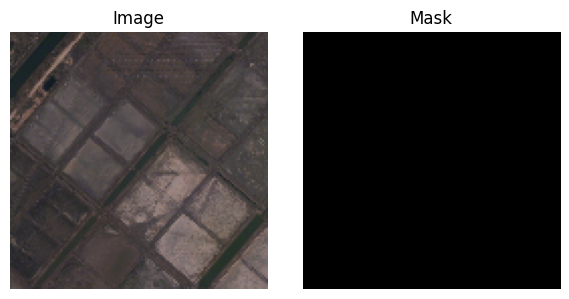

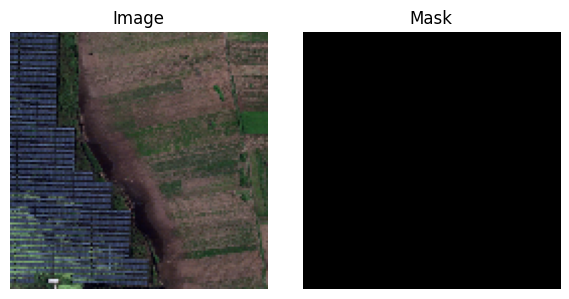

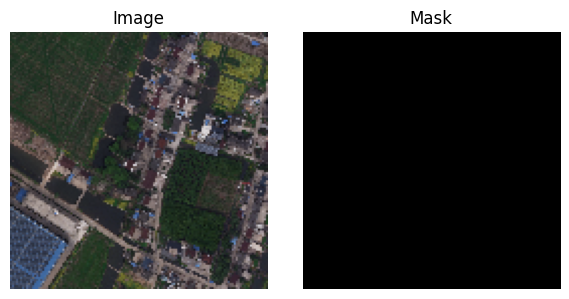

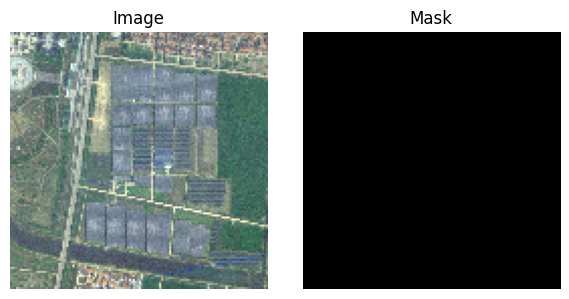

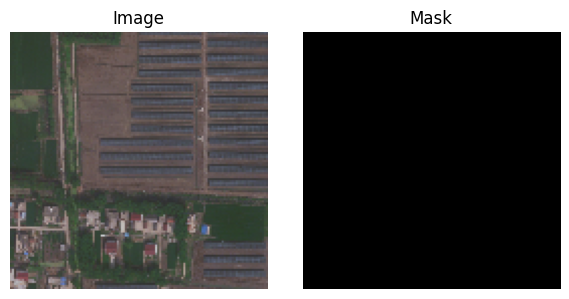

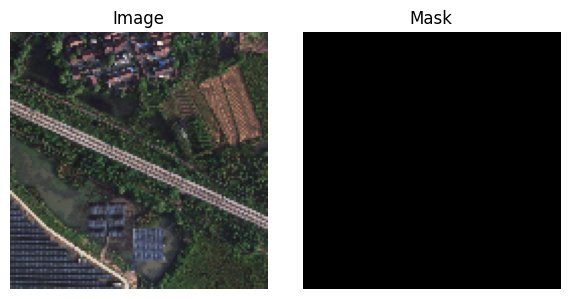

In [10]:
def load_image_mask(img_path, msk_path, img_size):
    # Image: OK to decode with 3 channels
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)  # BMP/PNG/JPG
    img = tf.image.resize(img, (img_size, img_size))
    img = tf.cast(img, tf.float32) / 255.0

    # Mask: decode with 3 channels (works for BMP/PNG/JPG), then convert to grayscale
    msk = tf.io.read_file(msk_path)
    msk = tf.image.decode_image(msk, channels=3, expand_animations=False)  # <-- changed from channels=1
    msk = tf.image.rgb_to_grayscale(msk)                                   # <-- ensure single channel
    msk = tf.image.resize(msk, (img_size, img_size), method="nearest")
    msk = tf.cast(msk > 127, tf.float32)                                   # binarize
    return img.numpy(), msk.numpy()

sub = df[df["split"]=="train"].sample(n=min(6, len(df)))
for _, r in sub.iterrows():
    img, msk = load_image_mask(r.image_path, r.mask_path, IMG_SIZE)
    fig, ax = plt.subplots(1, 2, figsize=(6,3))
    ax[0].imshow(img); ax[0].set_title("Image"); ax[0].axis("off")
    ax[1].imshow(msk.squeeze(), cmap="gray"); ax[1].set_title("Mask"); ax[1].axis("off")
    plt.tight_layout()
    plt.show()


# Train segmentation (U-Net + MobileNetV2 encoder)

In [12]:
os.makedirs(RUN_DIR, exist_ok=True)

cmd = [
    sys.executable, "-m", "src.seg.train_seg",
    "--csv", SPLITS_CSV, "--out", RUN_DIR,
    "--epochs", str(EPOCHS), "--batch", str(BATCH), "--img", str(IMG_SIZE),
]
print("Running:", " ".join(cmd))
subprocess.run(cmd, check=True)
print("Saved model & logs in:", RUN_DIR)


Running: C:\ProgramData\anaconda3\envs\DeepLearningEnvironment\python.exe -m src.seg.train_seg --csv data/segmentation/splits.csv --out reports/seg_unet --epochs 8 --batch 24 --img 128
Saved model & logs in: reports/seg_unet


## Plot training history

,epoch,binary_accuracy,dice_coef,iou,loss,val_binary_accuracy,val_dice_coef,val_iou,val_loss
0,0,0.932483,0.028458,0.570260,0.209784,0.943177,0.058654,0.825163,0.087000
1,1,0.964122,0.071530,0.866522,0.064222,0.971241,0.088438,0.899778,0.059980
2,2,0.981894,0.097864,0.906953,0.042438,0.984001,0.107013,0.919445,0.039245
3,3,0.987791,0.114071,0.927557,0.030713,0.986686,0.123169,0.937789,0.034832
4,4,0.990316,0.123459,0.937768,0.024609,0.988888,0.127362,0.926004,0.028252
5,5,0.991794,0.128210,0.943800,0.020761,0.990993,0.130763,0.946425,0.022522
6,6,0.992358,0.130478,0.944712,0.019503,0.988478,0.126886,0.950355,0.044163
7,7,0.993304,0.134240,0.947422,0.016746,0.991774,0.134191,0.947246,0.020436


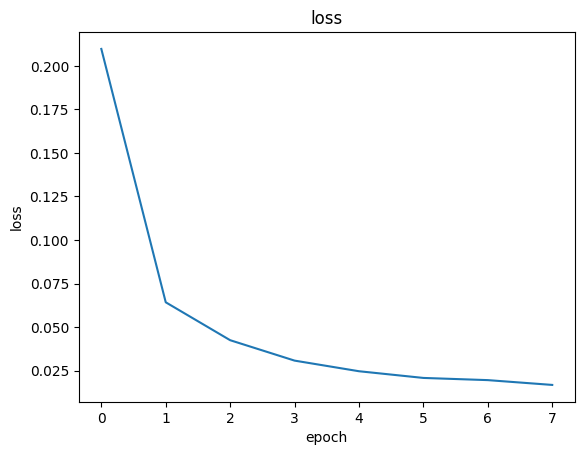

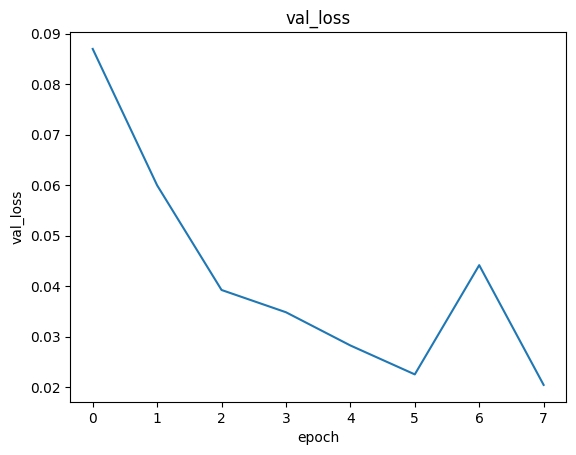

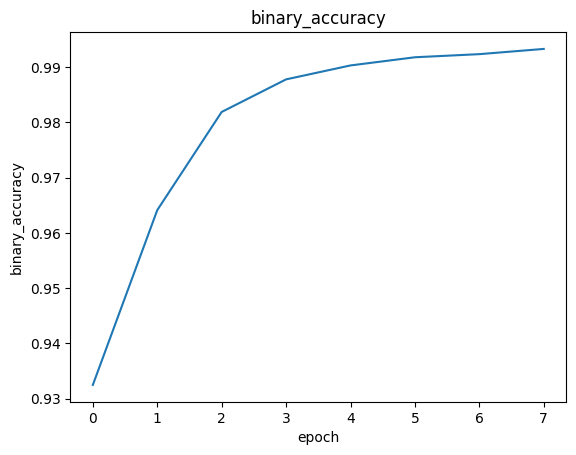

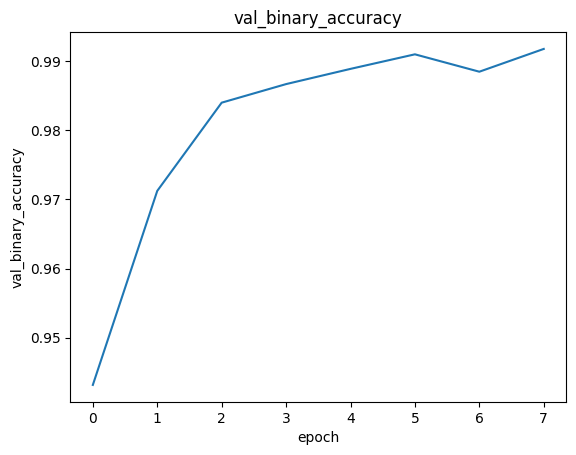

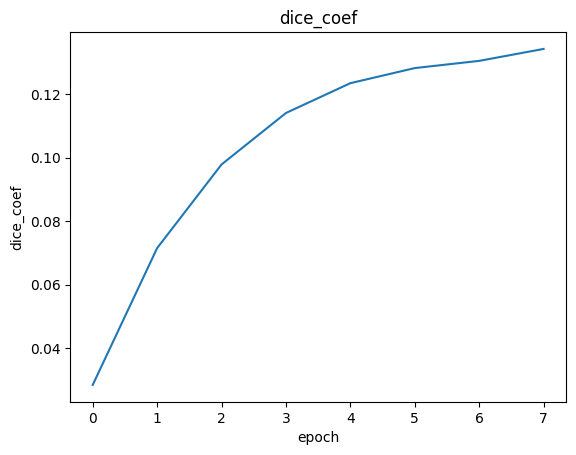

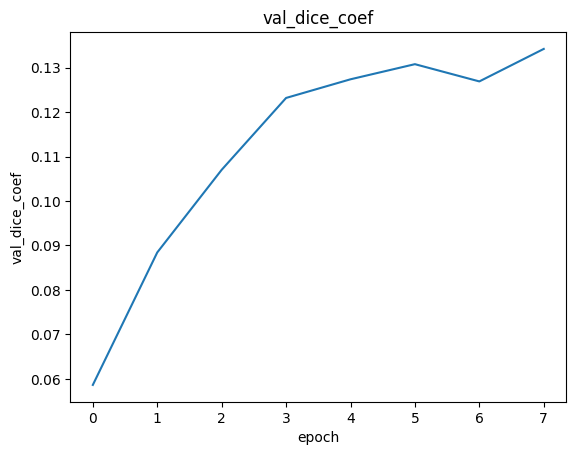

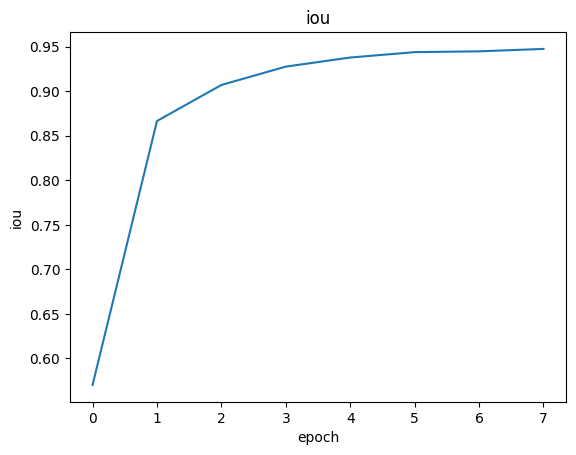

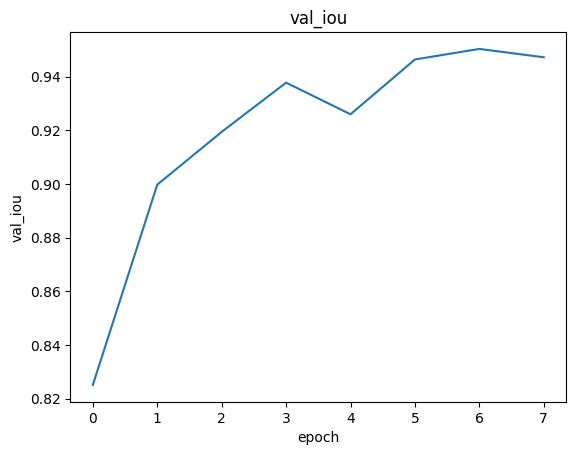

In [14]:
hist_path = os.path.join(RUN_DIR, "history.csv")
h = pd.read_csv(hist_path)
display(h.head(10))

for col in ["loss","val_loss","binary_accuracy","val_binary_accuracy","dice_coef","val_dice_coef","iou","val_iou"]:
    if col in h:
        plt.figure()
        plt.plot(h[col])
        plt.title(col)
        plt.xlabel("epoch"); plt.ylabel(col)
        plt.show()


# Evaluate on the test set

In [25]:
EVAL_DIR = os.path.join(RUN_DIR, "eval")
cmd = [
    sys.executable, "-m", "src.seg.eval_seg",
    "--csv", SPLITS_CSV,
    "--model", os.path.join(RUN_DIR, "best.keras"),
    "--out", EVAL_DIR,
    "--img", str(IMG_SIZE),
]
print("Running:", " ".join(cmd))
subprocess.run(cmd, check=True)

with open(os.path.join(EVAL_DIR, "test_metrics.json"), "r") as f:
    metrics = json.load(f)
metrics


Running: C:\ProgramData\anaconda3\envs\DeepLearningEnvironment\python.exe -m src.seg.eval_seg --csv data/segmentation/splits.csv --model reports/seg_unet\best.keras --out reports/seg_unet\eval --img 128


{'binary_accuracy': 0.9907481074333191,
 'dice': 0.13608840107917786,
 'iou': 0.9294689297676086,
 'n_test': 744}

In [27]:
metrics.keys()

dict_keys(['binary_accuracy', 'dice', 'iou', 'n_test'])

In [29]:
metrics.values()

dict_values([0.9907481074333191, 0.13608840107917786, 0.9294689297676086, 744])

In [31]:
pd.DataFrame(metrics.values(),index=metrics.keys(),columns=['value'])

,value
binary_accuracy,0.990748
dice,0.136088
iou,0.929469
n_test,744.000000


# Visualising the Segmentation Results

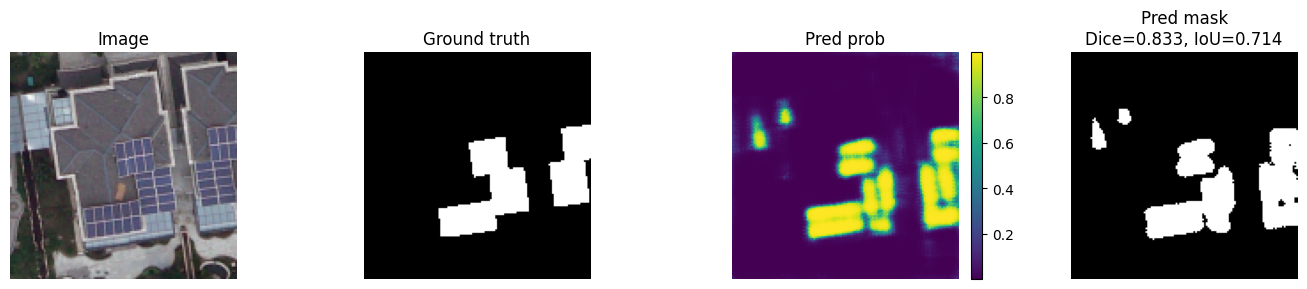

In [58]:
CSV         = "data/segmentation/splits.csv"
MODEL_PATH  = "reports/seg_unet/best.keras"   # or last.keras
IMG_SIZE    = 128                              # must match what you trained with
THRESH      = 0.5                              # binarization threshold for predictions

# --- BMP-safe loader (3-channel decode then grayscale for masks) ---
def load_image_mask_bmp_safe(img_path, msk_path, img_size):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)  # BMP/PNG/JPG
    img = tf.image.resize(img, (img_size, img_size))
    img = tf.cast(img, tf.float32) / 255.0

    msk = tf.io.read_file(msk_path)
    msk = tf.image.decode_image(msk, channels=3, expand_animations=False)  # BMP-safe
    msk = tf.image.rgb_to_grayscale(msk)
    msk = tf.image.resize(msk, (img_size, img_size), method="nearest")
    msk = tf.cast(msk > 127, tf.float32)  # binarize GT
    return img.numpy(), msk.numpy().squeeze()

def dice_np(y_true, y_pred, eps=1e-7):
    y_true = y_true.astype(np.float32).ravel()
    y_pred = y_pred.astype(np.float32).ravel()
    inter  = (y_true * y_pred).sum()
    return (2*inter + eps) / (y_true.sum() + y_pred.sum() + eps)

def iou_np(y_true, y_pred, eps=1e-7):
    y_true = y_true.astype(np.float32).ravel()
    y_pred = y_pred.astype(np.float32).ravel()
    inter  = (y_true * y_pred).sum()
    union  = y_true.sum() + y_pred.sum() - inter
    return (inter + eps) / (union + eps)

# Load a random test sample
df = pd.read_csv(CSV)
test_df = df[df["split"] == "test"]
row = test_df.sample(2).iloc[0]

img, msk_true = load_image_mask_bmp_safe(row.image_path, row.mask_path, IMG_SIZE)

# Load model (no custom objects needed for inference)
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

# Predict
prob = model(tf.expand_dims(img, 0), training=False).numpy()[0, :, :, 0]
msk_pred = (prob >= THRESH).astype(np.float32)

# Metrics
d = dice_np(msk_true, msk_pred)
j = iou_np(msk_true, msk_pred)

# Plot
fig, ax = plt.subplots(1, 4, figsize=(14, 3))
ax[0].imshow(img);                  ax[0].set_title("Image");               ax[0].axis("off")
ax[1].imshow(msk_true, cmap="gray");ax[1].set_title("Ground truth");        ax[1].axis("off")
im = ax[2].imshow(prob, cmap="viridis"); ax[2].set_title("Pred prob");      ax[2].axis("off")
fig.colorbar(im, ax=ax[2], fraction=0.046, pad=0.04)
ax[3].imshow(msk_pred, cmap="gray"); ax[3].set_title(f"Pred mask\nDice={d:.3f}, IoU={j:.3f}"); ax[3].axis("off")
plt.tight_layout(); plt.show()


# Classification Task

#### Available Models: inceptionv3_net_proposed, cnn_plain, mobilenetv3, densenet, vgg16, vgg19, resnet50, inceptionv3_base

## Train the Classifier Models

In [38]:
# Path to your classification CSV
CLS_CSV = "data/classification/splits_spfnet.csv"   # change if different

# Train *all* available classifiers from the repo
MODELS = [
    "cnn_plain",
    "mobilenetv3",
    "densenet",
    "vgg16",
    "vgg19",
    "resnet50",
    "inceptionv3_base",
    "inceptionv3_net_proposed",   # the "proposed" head (InceptionV3 backbone)
]

# Shared hyperparams
IMG    = 256
BATCH  = 32
EPOCHS = 30

# Where to dump all runs + summary
RUNS_ROOT = Path("reports/cls_runs")
RUNS_ROOT.mkdir(parents=True, exist_ok=True)

# Environment knobs (helps avoid GPU OOM & spam)
BASE_ENV = os.environ.copy()
BASE_ENV["TF_CPP_MIN_LOG_LEVEL"] = "2"                 # quiet TF logs
BASE_ENV["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"         # let TF grow GPU memory gradually


## Helper Functions

In [47]:
def run_training_and_eval(model_name, csv_path, img, batch, epochs, runs_root, base_env):
    """Train + eval one classifier; return (status, run_dir, metrics_dict or None, stderr_tail)."""
    stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    run_dir = runs_root / f"{model_name}"
    run_dir.mkdir(parents=True, exist_ok=True)

    # 1) Train
    train_cmd = [
        sys.executable, "-m", "src.cls.train_cls",
        "--csv",   csv_path,
        "--model_name", model_name,
        "--out",   str(run_dir),
        "--epochs", str(epochs),
        "--batch",  str(batch),
        "--img",    str(img),
    ]
    print(f"\n=== Training {model_name} ===\n$ {' '.join(train_cmd)}")
    train_proc = subprocess.run(train_cmd, capture_output=True, text=True, env=base_env)
    print("---- TRAIN STDOUT (tail) ----\n", train_proc.stdout[-1500:])
    print("---- TRAIN STDERR (tail) ----\n", train_proc.stderr[-1500:])
    if train_proc.returncode != 0:
        return ("TRAIN_FAIL", str(run_dir), None, train_proc.stderr[-2000:])

    # 2) Eval
    eval_dir = run_dir / "eval"
    eval_cmd = [
        sys.executable, "-m", "src.cls.eval_cls",
        "--csv",   csv_path,
        "--model", str(run_dir / "best.keras"),
        "--out",   str(eval_dir),
        "--img",   str(img),
    ]
    print(f"\n=== Evaluating {model_name} ===\n$ {' '.join(eval_cmd)}")
    eval_proc = subprocess.run(eval_cmd, capture_output=True, text=True, env=base_env)
    print("---- EVAL STDOUT (tail) ----\n", eval_proc.stdout[-1500:])
    print("---- EVAL STDERR (tail) ----\n", eval_proc.stderr[-1500:])
    if eval_proc.returncode != 0:
        return ("EVAL_FAIL", str(run_dir), None, eval_proc.stderr[-2000:])

    # 3) Read metrics JSON if present
    metrics_path = eval_dir / "test_metrics.json"
    metrics = None
    if metrics_path.exists():
        try:
            with open(metrics_path, "r", encoding="utf-8") as f:
                metrics = json.load(f)
        except Exception as e:
            print("Could not read test_metrics.json:", e)

    return ("OK", str(run_dir), metrics, eval_proc.stderr[-1000:])


## Train and Evalual ALL classifoer models and build a summary table

In [50]:
results = []
failures = []

for m in MODELS:
    status, run_dir, metrics, err_tail = run_training_and_eval(
        model_name=m,
        csv_path=CLS_CSV,
        img=IMG,
        batch=BATCH,
        epochs=EPOCHS,
        runs_root=RUNS_ROOT,
        base_env=BASE_ENV
    )
    row = {
        "model": m,
        "status": status,
        "run_dir": run_dir,
        "acc": None,
        "macro_f1": None,
        "support": None,
    }
    if metrics:
        # Try to pull common fields; fall back gracefully if keys differ in your eval script
        row["acc"] = metrics.get("accuracy") or metrics.get("test_accuracy") or metrics.get("acc")
        row["macro_f1"] = metrics.get("macro_f1") or metrics.get("f1_macro")
        row["support"] = metrics.get("test_support") or metrics.get("n_test")
    else:
        if status != "OK":
            failures.append((m, status, err_tail))

    results.append(row)

summary_df = pd.DataFrame(results).sort_values(by=["status","acc"], ascending=[True, False])
display(summary_df)

# Save summary
summary_csv = RUNS_ROOT / "summary.csv"
summary_df.to_csv(summary_csv, index=False)
print("Saved summary ->", summary_csv)

if failures:
    print("\nSome models failed:")
    for m, st, err in failures:
        print(f"\n[{m}] {st}\n{err}")



=== Training cnn_plain ===
$ C:\ProgramData\anaconda3\envs\DeepLearningEnvironment\python.exe -m src.cls.train_cls --csv data/classification/splits_spfnet.csv --model_name cnn_plain --out reports\cls_runs\cnn_plain --epochs 30 --batch 32 --img 256
---- TRAIN STDOUT (tail) ----
 ====>...............] - ETA: 0s - loss: 1.7229 - accuracy: 0.2639
17/17 [==============================] - 1s 73ms/step - loss: 1.7208 - accuracy: 0.2500 - val_loss: 1.7201 - val_accuracy: 0.2384
Epoch 7/30

17/17 [==============================] - 1s 69ms/step - loss: 1.7271 - accuracy: 0.2252 - val_loss: 1.7202 - val_accuracy: 0.2384

---- TRAIN STDERR (tail) ----
 

=== Evaluating cnn_plain ===
$ C:\ProgramData\anaconda3\envs\DeepLearningEnvironment\python.exe -m src.cls.eval_cls --csv data/classification/splits_spfnet.csv --model reports\cls_runs\cnn_plain\best.keras --out reports\cls_runs\cnn_plain\eval --img 256
---- EVAL STDOUT (tail) ----
 Saved metrics and confusion matrix.

---- EVAL STDERR (tail) ---

,model,status,run_dir,acc,macro_f1,support
2,densenet,OK,reports\cls_runs\densenet,0.784530,None,None
7,inceptionv3_net_proposed,OK,reports\cls_runs\inceptionv3_net_proposed,0.734807,None,None
3,vgg16,OK,reports\cls_runs\vgg16,0.707182,None,None
4,vgg19,OK,reports\cls_runs\vgg19,0.635359,None,None
6,inceptionv3_base,OK,reports\cls_runs\inceptionv3_base,0.541436,None,None
5,resnet50,OK,reports\cls_runs\resnet50,0.436464,None,None
1,mobilenetv3,OK,reports\cls_runs\mobilenetv3,0.359116,None,None
0,cnn_plain,OK,reports\cls_runs\cnn_plain,0.232044,None,None


Saved summary -> reports\cls_runs\summary.csv


# View the Permofance Metrics for Each Model